# Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Dataset

In [ ]:
!wget https://raw.githubusercontent.com/prateekjoshi565/Fine-Tuning-BERT/master/spamdata_v2.csv

--2025-01-28 22:05:43--  https://raw.githubusercontent.com/prateekjoshi565/Fine-Tuning-BERT/master/spamdata_v2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467438 (456K) [text/plain]
Saving to: ‘spamdata_v2.csv’

spamdata_v2.csv     100%[===================>] 456.48K  --.-KB/s    in 0.02s   

2025-01-28 22:05:43 (25.7 MB/s) - ‘spamdata_v2.csv’ saved [467438/467438]



In [ ]:
# specify GPU
device = torch.device("cuda")

In [ ]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.2,
                                                                    stratify=df['label'])

In [ ]:
# split train dataset into train, validation and test sets
val_text, test_text, val_labels, test_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.5,
                                                                    stratify=df['label'])

# Model and Training

In [ ]:
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')


# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

<Axes: >

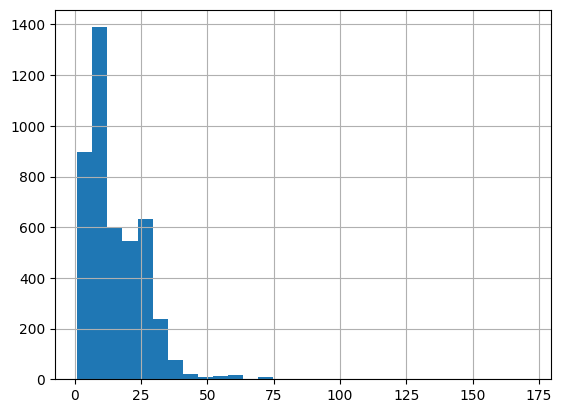

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

<Axes: >

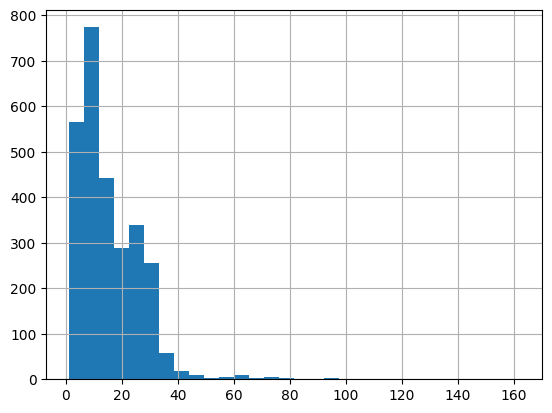

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in val_text]

pd.Series(seq_len).hist(bins = 30)

<Axes: >

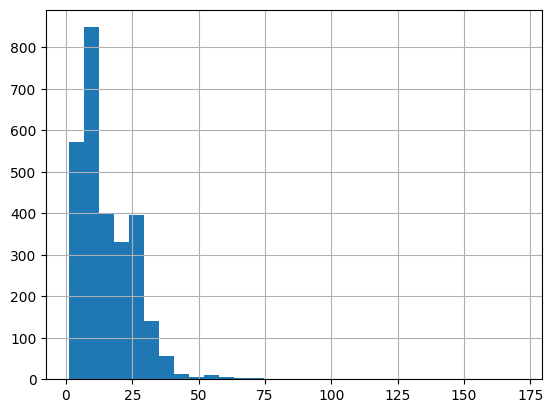

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in test_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
train_y.size()

torch.Size([4457])

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# dataLoader for validation set
test_data = TensorDataset(test_seq, test_mask, test_y)

test_sampler = SequentialSampler(test_data)

test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
  param.requires_grad = False

In [ ]:
print(bert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
class BERT_Spam(nn.Module):
    def __init__(self, bert):
      super(BERT_Spam, self).__init__()
      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.5)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,256)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(256,2)

      #softmax activation function
      #self.softmax = nn.LogSoftmax(dim=1)
      self.softmax = nn.Softmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      output = self.bert(sent_id, attention_mask=mask)

      # For BERT model
      #hidden_state = output[1]

      # For handling distilbert output
      hidden_state = output[0][:, 0, :]

      x = self.fc1(hidden_state)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      #x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Spam(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57748121 3.72658863]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy = nn.CrossEntropyLoss()

# number of training epochs
epochs = 100

In [ ]:
def train():
  #print('1')
  model.train()
  #print('2')
  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(tqdm(train_dataloader)):
    #print('inside loop')
    # progress update after every 50 batches.
    #if step % 50 == 0 and not step == 0:
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    #print('here!!')
    preds = model(sent_id, mask)
    #print('here 2!!')
    # print(f"labels: {labels}")
    # print(labels.shape)
    #print(f"preds: {preds}")
    #print(preds.shape)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    total_labels.append(labels)


  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels = np.concatenate(total_labels, axis=0)
  accuracy = np.sum(np.argmax(total_preds, axis=1) == total_labels) / len(total_preds)

  #returns the loss and predictions
  return avg_loss, accuracy


In [ ]:
def evaluate(model, mode = "val"):
  if mode == "val":
    data_loader = val_dataloader
  elif mode == "test":
    data_loader = test_dataloader
  else:
    raise ValueError("Invalid mode. Must be 'val' or 'test'.")

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(tqdm(data_loader)):

    # Progress update every 50 batches.
    #if step % 50 == 0 and not step == 0:

      # Report progress.
      #print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      #print(f"preds: {preds}")

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()

      total_preds.append(preds)
      total_labels.append(labels)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels = np.concatenate(total_labels, axis=0)

  # print(f"total_preds: {total_preds}")
  # print(f"total_preds.shape: {total_preds.shape}")
  # print(f"total_labels: {total_labels}")
  # print(f"total_labels.shape: {total_labels.shape}")
  accuracy = np.sum(np.argmax(total_preds, axis=1) == total_labels) / len(total_preds)

  if mode == "test":
    report = classification_report(total_labels, np.argmax(total_preds, axis=1), target_names=["Not spam", "Spam"])
    return avg_loss, accuracy, report
  else:
    return avg_loss, accuracy

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')
best_valid_accuracy = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
train_accuracies = []
valid_accuracies = []

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy = train()

    #evaluate model
    valid_loss, valid_accuracy = evaluate(model, mode = "val")

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_distilbert.pt')

    if valid_accuracy > best_valid_accuracy:
        print(f"Validation accuracy improved from {best_valid_accuracy} to {valid_accuracy}, saving model...")
        best_valid_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'saved_weights_accuracy_distilbert.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


 Epoch 1 / 100


100%|██████████| 140/140 [00:02<00:00, 50.15it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.34it/s]



Training Loss: 0.486
Validation Loss: 0.400
Training Accuracy: 0.866
Validation Accuracy: 0.866
Validation accuracy improved from 0 to 0.8657573582196698, saving model...

 Epoch 2 / 100


100%|██████████| 140/140 [00:02<00:00, 50.63it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.65it/s]



Training Loss: 0.378
Validation Loss: 0.346
Training Accuracy: 0.866
Validation Accuracy: 0.866

 Epoch 3 / 100


100%|██████████| 140/140 [00:02<00:00, 50.67it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 56.39it/s]



Training Loss: 0.342
Validation Loss: 0.317
Training Accuracy: 0.866
Validation Accuracy: 0.866

 Epoch 4 / 100


100%|██████████| 140/140 [00:02<00:00, 51.49it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.38it/s]



Training Loss: 0.315
Validation Loss: 0.288
Training Accuracy: 0.866
Validation Accuracy: 0.866

 Epoch 5 / 100


100%|██████████| 140/140 [00:02<00:00, 50.98it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.73it/s]



Training Loss: 0.288
Validation Loss: 0.262
Training Accuracy: 0.867
Validation Accuracy: 0.867
Validation accuracy improved from 0.8657573582196698 to 0.8668341708542714, saving model...

 Epoch 6 / 100


100%|██████████| 140/140 [00:02<00:00, 48.47it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.19it/s]



Training Loss: 0.263
Validation Loss: 0.238
Training Accuracy: 0.874
Validation Accuracy: 0.877
Validation accuracy improved from 0.8668341708542714 to 0.8765254845656856, saving model...

 Epoch 7 / 100


100%|██████████| 140/140 [00:02<00:00, 48.96it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.42it/s]



Training Loss: 0.240
Validation Loss: 0.215
Training Accuracy: 0.889
Validation Accuracy: 0.897
Validation accuracy improved from 0.8765254845656856 to 0.8969849246231156, saving model...

 Epoch 8 / 100


100%|██████████| 140/140 [00:02<00:00, 48.48it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.71it/s]



Training Loss: 0.220
Validation Loss: 0.196
Training Accuracy: 0.904
Validation Accuracy: 0.917
Validation accuracy improved from 0.8969849246231156 to 0.9167264895908112, saving model...

 Epoch 9 / 100


100%|██████████| 140/140 [00:02<00:00, 48.84it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.95it/s]



Training Loss: 0.202
Validation Loss: 0.179
Training Accuracy: 0.922
Validation Accuracy: 0.934
Validation accuracy improved from 0.9167264895908112 to 0.9343144292893036, saving model...

 Epoch 10 / 100


100%|██████████| 140/140 [00:02<00:00, 48.89it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.34it/s]



Training Loss: 0.188
Validation Loss: 0.166
Training Accuracy: 0.934
Validation Accuracy: 0.943
Validation accuracy improved from 0.9343144292893036 to 0.9432878679109835, saving model...

 Epoch 11 / 100


100%|██████████| 140/140 [00:02<00:00, 49.48it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.04it/s]



Training Loss: 0.174
Validation Loss: 0.155
Training Accuracy: 0.940
Validation Accuracy: 0.948
Validation accuracy improved from 0.9432878679109835 to 0.947954055994257, saving model...

 Epoch 12 / 100


100%|██████████| 140/140 [00:02<00:00, 48.92it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.49it/s]



Training Loss: 0.164
Validation Loss: 0.146
Training Accuracy: 0.945
Validation Accuracy: 0.952
Validation accuracy improved from 0.947954055994257 to 0.951543431442929, saving model...

 Epoch 13 / 100


100%|██████████| 140/140 [00:02<00:00, 49.03it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.12it/s]



Training Loss: 0.155
Validation Loss: 0.137
Training Accuracy: 0.948
Validation Accuracy: 0.955
Validation accuracy improved from 0.951543431442929 to 0.9547738693467337, saving model...

 Epoch 14 / 100


100%|██████████| 140/140 [00:02<00:00, 49.29it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.19it/s]



Training Loss: 0.146
Validation Loss: 0.131
Training Accuracy: 0.954
Validation Accuracy: 0.957
Validation accuracy improved from 0.9547738693467337 to 0.9565685570710696, saving model...

 Epoch 15 / 100


100%|██████████| 140/140 [00:02<00:00, 49.58it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.79it/s]



Training Loss: 0.142
Validation Loss: 0.125
Training Accuracy: 0.954
Validation Accuracy: 0.959
Validation accuracy improved from 0.9565685570710696 to 0.9587221823402728, saving model...

 Epoch 16 / 100


100%|██████████| 140/140 [00:02<00:00, 48.55it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.56it/s]



Training Loss: 0.135
Validation Loss: 0.120
Training Accuracy: 0.957
Validation Accuracy: 0.959
Validation accuracy improved from 0.9587221823402728 to 0.9594400574300072, saving model...

 Epoch 17 / 100


100%|██████████| 140/140 [00:02<00:00, 48.18it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.45it/s]



Training Loss: 0.129
Validation Loss: 0.116
Training Accuracy: 0.956
Validation Accuracy: 0.960
Validation accuracy improved from 0.9594400574300072 to 0.9601579325197416, saving model...

 Epoch 18 / 100


100%|██████████| 140/140 [00:02<00:00, 48.82it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.67it/s]



Training Loss: 0.124
Validation Loss: 0.112
Training Accuracy: 0.961
Validation Accuracy: 0.960

 Epoch 19 / 100


100%|██████████| 140/140 [00:02<00:00, 50.82it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.16it/s]



Training Loss: 0.122
Validation Loss: 0.108
Training Accuracy: 0.961
Validation Accuracy: 0.962
Validation accuracy improved from 0.9601579325197416 to 0.9619526202440776, saving model...

 Epoch 20 / 100


100%|██████████| 140/140 [00:02<00:00, 49.62it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.12it/s]



Training Loss: 0.118
Validation Loss: 0.105
Training Accuracy: 0.964
Validation Accuracy: 0.964
Validation accuracy improved from 0.9619526202440776 to 0.9644651830581479, saving model...

 Epoch 21 / 100


100%|██████████| 140/140 [00:02<00:00, 49.75it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.46it/s]



Training Loss: 0.118
Validation Loss: 0.103
Training Accuracy: 0.965
Validation Accuracy: 0.964

 Epoch 22 / 100


100%|██████████| 140/140 [00:02<00:00, 49.96it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.14it/s]



Training Loss: 0.116
Validation Loss: 0.100
Training Accuracy: 0.964
Validation Accuracy: 0.966
Validation accuracy improved from 0.9644651830581479 to 0.9662598707824839, saving model...

 Epoch 23 / 100


100%|██████████| 140/140 [00:02<00:00, 48.71it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.70it/s]



Training Loss: 0.114
Validation Loss: 0.098
Training Accuracy: 0.964
Validation Accuracy: 0.967
Validation accuracy improved from 0.9662598707824839 to 0.966618808327351, saving model...

 Epoch 24 / 100


100%|██████████| 140/140 [00:02<00:00, 49.43it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 55.18it/s]



Training Loss: 0.109
Validation Loss: 0.096
Training Accuracy: 0.964
Validation Accuracy: 0.968
Validation accuracy improved from 0.966618808327351 to 0.968413496051687, saving model...

 Epoch 25 / 100


100%|██████████| 140/140 [00:02<00:00, 48.91it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.71it/s]



Training Loss: 0.108
Validation Loss: 0.094
Training Accuracy: 0.967
Validation Accuracy: 0.968

 Epoch 26 / 100


100%|██████████| 140/140 [00:02<00:00, 49.87it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.79it/s]



Training Loss: 0.105
Validation Loss: 0.092
Training Accuracy: 0.966
Validation Accuracy: 0.968

 Epoch 27 / 100


100%|██████████| 140/140 [00:02<00:00, 49.82it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.43it/s]



Training Loss: 0.102
Validation Loss: 0.091
Training Accuracy: 0.968
Validation Accuracy: 0.969
Validation accuracy improved from 0.968413496051687 to 0.9687724335965542, saving model...

 Epoch 28 / 100


100%|██████████| 140/140 [00:02<00:00, 49.37it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.39it/s]



Training Loss: 0.104
Validation Loss: 0.089
Training Accuracy: 0.966
Validation Accuracy: 0.969
Validation accuracy improved from 0.9687724335965542 to 0.9691313711414213, saving model...

 Epoch 29 / 100


100%|██████████| 140/140 [00:02<00:00, 48.92it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.16it/s]



Training Loss: 0.098
Validation Loss: 0.088
Training Accuracy: 0.971
Validation Accuracy: 0.971
Validation accuracy improved from 0.9691313711414213 to 0.9705671213208902, saving model...

 Epoch 30 / 100


100%|██████████| 140/140 [00:02<00:00, 48.71it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.16it/s]



Training Loss: 0.099
Validation Loss: 0.087
Training Accuracy: 0.967
Validation Accuracy: 0.970

 Epoch 31 / 100


100%|██████████| 140/140 [00:02<00:00, 48.52it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.33it/s]



Training Loss: 0.096
Validation Loss: 0.086
Training Accuracy: 0.969
Validation Accuracy: 0.973
Validation accuracy improved from 0.9705671213208902 to 0.9727207465900933, saving model...

 Epoch 32 / 100


100%|██████████| 140/140 [00:02<00:00, 48.84it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.38it/s]



Training Loss: 0.099
Validation Loss: 0.085
Training Accuracy: 0.969
Validation Accuracy: 0.973
Validation accuracy improved from 0.9727207465900933 to 0.9734386216798278, saving model...

 Epoch 33 / 100


100%|██████████| 140/140 [00:02<00:00, 48.94it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.10it/s]



Training Loss: 0.095
Validation Loss: 0.084
Training Accuracy: 0.969
Validation Accuracy: 0.973

 Epoch 34 / 100


100%|██████████| 140/140 [00:02<00:00, 49.61it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 54.48it/s]



Training Loss: 0.095
Validation Loss: 0.082
Training Accuracy: 0.972
Validation Accuracy: 0.975
Validation accuracy improved from 0.9734386216798278 to 0.9752333094041636, saving model...

 Epoch 35 / 100


100%|██████████| 140/140 [00:02<00:00, 48.66it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.38it/s]



Training Loss: 0.092
Validation Loss: 0.082
Training Accuracy: 0.971
Validation Accuracy: 0.975

 Epoch 36 / 100


100%|██████████| 140/140 [00:02<00:00, 49.88it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.49it/s]



Training Loss: 0.091
Validation Loss: 0.081
Training Accuracy: 0.970
Validation Accuracy: 0.973

 Epoch 37 / 100


100%|██████████| 140/140 [00:02<00:00, 49.93it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.32it/s]



Training Loss: 0.092
Validation Loss: 0.080
Training Accuracy: 0.969
Validation Accuracy: 0.975

 Epoch 38 / 100


100%|██████████| 140/140 [00:02<00:00, 49.46it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.98it/s]



Training Loss: 0.092
Validation Loss: 0.079
Training Accuracy: 0.971
Validation Accuracy: 0.975

 Epoch 39 / 100


100%|██████████| 140/140 [00:02<00:00, 49.96it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.46it/s]



Training Loss: 0.094
Validation Loss: 0.078
Training Accuracy: 0.969
Validation Accuracy: 0.975

 Epoch 40 / 100


100%|██████████| 140/140 [00:02<00:00, 49.32it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.64it/s]



Training Loss: 0.090
Validation Loss: 0.078
Training Accuracy: 0.973
Validation Accuracy: 0.975

 Epoch 41 / 100


100%|██████████| 140/140 [00:02<00:00, 48.88it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.97it/s]



Training Loss: 0.086
Validation Loss: 0.077
Training Accuracy: 0.973
Validation Accuracy: 0.975

 Epoch 42 / 100


100%|██████████| 140/140 [00:02<00:00, 49.87it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.38it/s]



Training Loss: 0.087
Validation Loss: 0.076
Training Accuracy: 0.969
Validation Accuracy: 0.975

 Epoch 43 / 100


100%|██████████| 140/140 [00:02<00:00, 48.48it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.89it/s]



Training Loss: 0.088
Validation Loss: 0.076
Training Accuracy: 0.972
Validation Accuracy: 0.975

 Epoch 44 / 100


100%|██████████| 140/140 [00:02<00:00, 49.82it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.21it/s]



Training Loss: 0.085
Validation Loss: 0.075
Training Accuracy: 0.973
Validation Accuracy: 0.976
Validation accuracy improved from 0.9752333094041636 to 0.9755922469490309, saving model...

 Epoch 45 / 100


100%|██████████| 140/140 [00:02<00:00, 48.36it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.29it/s]



Training Loss: 0.084
Validation Loss: 0.074
Training Accuracy: 0.973
Validation Accuracy: 0.975

 Epoch 46 / 100


100%|██████████| 140/140 [00:02<00:00, 49.90it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.41it/s]



Training Loss: 0.085
Validation Loss: 0.073
Training Accuracy: 0.973
Validation Accuracy: 0.976
Validation accuracy improved from 0.9755922469490309 to 0.9759511844938981, saving model...

 Epoch 47 / 100


100%|██████████| 140/140 [00:02<00:00, 48.18it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.55it/s]



Training Loss: 0.085
Validation Loss: 0.073
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 48 / 100


100%|██████████| 140/140 [00:02<00:00, 49.65it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.25it/s]



Training Loss: 0.082
Validation Loss: 0.072
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 49 / 100


100%|██████████| 140/140 [00:02<00:00, 49.50it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.42it/s]



Training Loss: 0.081
Validation Loss: 0.072
Training Accuracy: 0.975
Validation Accuracy: 0.976

 Epoch 50 / 100


100%|██████████| 140/140 [00:02<00:00, 49.96it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.56it/s]



Training Loss: 0.080
Validation Loss: 0.072
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 51 / 100


100%|██████████| 140/140 [00:02<00:00, 50.00it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.11it/s]



Training Loss: 0.081
Validation Loss: 0.071
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 52 / 100


100%|██████████| 140/140 [00:02<00:00, 49.25it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.72it/s]



Training Loss: 0.079
Validation Loss: 0.070
Training Accuracy: 0.973
Validation Accuracy: 0.976
Validation accuracy improved from 0.9759511844938981 to 0.9763101220387652, saving model...

 Epoch 53 / 100


100%|██████████| 140/140 [00:02<00:00, 48.14it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.36it/s]



Training Loss: 0.083
Validation Loss: 0.070
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 54 / 100


100%|██████████| 140/140 [00:02<00:00, 48.98it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.79it/s]



Training Loss: 0.082
Validation Loss: 0.070
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 55 / 100


100%|██████████| 140/140 [00:02<00:00, 48.76it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.08it/s]



Training Loss: 0.083
Validation Loss: 0.069
Training Accuracy: 0.973
Validation Accuracy: 0.976

 Epoch 56 / 100


100%|██████████| 140/140 [00:02<00:00, 49.01it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.73it/s]



Training Loss: 0.077
Validation Loss: 0.069
Training Accuracy: 0.976
Validation Accuracy: 0.976

 Epoch 57 / 100


100%|██████████| 140/140 [00:02<00:00, 49.60it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.65it/s]



Training Loss: 0.077
Validation Loss: 0.068
Training Accuracy: 0.974
Validation Accuracy: 0.976

 Epoch 58 / 100


100%|██████████| 140/140 [00:02<00:00, 49.35it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.11it/s]



Training Loss: 0.079
Validation Loss: 0.067
Training Accuracy: 0.975
Validation Accuracy: 0.977
Validation accuracy improved from 0.9763101220387652 to 0.9766690595836325, saving model...

 Epoch 59 / 100


100%|██████████| 140/140 [00:02<00:00, 48.19it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.61it/s]



Training Loss: 0.079
Validation Loss: 0.067
Training Accuracy: 0.973
Validation Accuracy: 0.977

 Epoch 60 / 100


100%|██████████| 140/140 [00:02<00:00, 49.59it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.50it/s]



Training Loss: 0.077
Validation Loss: 0.066
Training Accuracy: 0.974
Validation Accuracy: 0.977

 Epoch 61 / 100


100%|██████████| 140/140 [00:02<00:00, 49.27it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.73it/s]



Training Loss: 0.075
Validation Loss: 0.067
Training Accuracy: 0.978
Validation Accuracy: 0.976

 Epoch 62 / 100


100%|██████████| 140/140 [00:02<00:00, 49.49it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.03it/s]



Training Loss: 0.074
Validation Loss: 0.066
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 63 / 100


100%|██████████| 140/140 [00:02<00:00, 49.33it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.22it/s]



Training Loss: 0.074
Validation Loss: 0.066
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 64 / 100


100%|██████████| 140/140 [00:02<00:00, 49.35it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.12it/s]



Training Loss: 0.071
Validation Loss: 0.066
Training Accuracy: 0.978
Validation Accuracy: 0.977

 Epoch 65 / 100


100%|██████████| 140/140 [00:02<00:00, 49.71it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.05it/s]



Training Loss: 0.075
Validation Loss: 0.065
Training Accuracy: 0.977
Validation Accuracy: 0.977

 Epoch 66 / 100


100%|██████████| 140/140 [00:02<00:00, 47.96it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.25it/s]



Training Loss: 0.076
Validation Loss: 0.064
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 67 / 100


100%|██████████| 140/140 [00:02<00:00, 49.41it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.11it/s]



Training Loss: 0.072
Validation Loss: 0.064
Training Accuracy: 0.978
Validation Accuracy: 0.977

 Epoch 68 / 100


100%|██████████| 140/140 [00:02<00:00, 48.81it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.70it/s]



Training Loss: 0.073
Validation Loss: 0.063
Training Accuracy: 0.975
Validation Accuracy: 0.977

 Epoch 69 / 100


100%|██████████| 140/140 [00:02<00:00, 49.53it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.05it/s]



Training Loss: 0.072
Validation Loss: 0.063
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 70 / 100


100%|██████████| 140/140 [00:02<00:00, 49.37it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.20it/s]



Training Loss: 0.074
Validation Loss: 0.063
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 71 / 100


100%|██████████| 140/140 [00:02<00:00, 49.52it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.04it/s]



Training Loss: 0.073
Validation Loss: 0.063
Training Accuracy: 0.978
Validation Accuracy: 0.977

 Epoch 72 / 100


100%|██████████| 140/140 [00:02<00:00, 49.74it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 49.90it/s]



Training Loss: 0.069
Validation Loss: 0.062
Training Accuracy: 0.977
Validation Accuracy: 0.978
Validation accuracy improved from 0.9766690595836325 to 0.9781048097631012, saving model...

 Epoch 73 / 100


100%|██████████| 140/140 [00:02<00:00, 48.36it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 53.31it/s]



Training Loss: 0.070
Validation Loss: 0.062
Training Accuracy: 0.977
Validation Accuracy: 0.977

 Epoch 74 / 100


100%|██████████| 140/140 [00:02<00:00, 49.87it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.77it/s]



Training Loss: 0.075
Validation Loss: 0.062
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 75 / 100


100%|██████████| 140/140 [00:02<00:00, 49.35it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.63it/s]



Training Loss: 0.071
Validation Loss: 0.062
Training Accuracy: 0.978
Validation Accuracy: 0.977

 Epoch 76 / 100


100%|██████████| 140/140 [00:02<00:00, 48.24it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.37it/s]



Training Loss: 0.070
Validation Loss: 0.061
Training Accuracy: 0.976
Validation Accuracy: 0.979
Validation accuracy improved from 0.9781048097631012 to 0.9788226848528356, saving model...

 Epoch 77 / 100


100%|██████████| 140/140 [00:02<00:00, 47.89it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.69it/s]



Training Loss: 0.070
Validation Loss: 0.061
Training Accuracy: 0.976
Validation Accuracy: 0.979

 Epoch 78 / 100


100%|██████████| 140/140 [00:02<00:00, 49.79it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.81it/s]



Training Loss: 0.070
Validation Loss: 0.061
Training Accuracy: 0.978
Validation Accuracy: 0.979

 Epoch 79 / 100


100%|██████████| 140/140 [00:02<00:00, 49.47it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.66it/s]



Training Loss: 0.071
Validation Loss: 0.060
Training Accuracy: 0.976
Validation Accuracy: 0.979

 Epoch 80 / 100


100%|██████████| 140/140 [00:02<00:00, 49.53it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.91it/s]



Training Loss: 0.070
Validation Loss: 0.061
Training Accuracy: 0.978
Validation Accuracy: 0.977

 Epoch 81 / 100


100%|██████████| 140/140 [00:02<00:00, 49.72it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.62it/s]



Training Loss: 0.068
Validation Loss: 0.060
Training Accuracy: 0.978
Validation Accuracy: 0.979

 Epoch 82 / 100


100%|██████████| 140/140 [00:02<00:00, 48.81it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.92it/s]



Training Loss: 0.068
Validation Loss: 0.059
Training Accuracy: 0.978
Validation Accuracy: 0.979

 Epoch 83 / 100


100%|██████████| 140/140 [00:02<00:00, 48.35it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.84it/s]



Training Loss: 0.070
Validation Loss: 0.059
Training Accuracy: 0.976
Validation Accuracy: 0.979

 Epoch 84 / 100


100%|██████████| 140/140 [00:02<00:00, 48.19it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.59it/s]



Training Loss: 0.073
Validation Loss: 0.060
Training Accuracy: 0.976
Validation Accuracy: 0.977

 Epoch 85 / 100


100%|██████████| 140/140 [00:02<00:00, 49.68it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.47it/s]



Training Loss: 0.068
Validation Loss: 0.059
Training Accuracy: 0.979
Validation Accuracy: 0.979

 Epoch 86 / 100


100%|██████████| 140/140 [00:02<00:00, 49.55it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.15it/s]



Training Loss: 0.069
Validation Loss: 0.059
Training Accuracy: 0.977
Validation Accuracy: 0.979

 Epoch 87 / 100


100%|██████████| 140/140 [00:02<00:00, 49.15it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.05it/s]



Training Loss: 0.069
Validation Loss: 0.058
Training Accuracy: 0.976
Validation Accuracy: 0.979
Validation accuracy improved from 0.9788226848528356 to 0.9791816223977028, saving model...

 Epoch 88 / 100


100%|██████████| 140/140 [00:02<00:00, 48.27it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.58it/s]



Training Loss: 0.068
Validation Loss: 0.059
Training Accuracy: 0.980
Validation Accuracy: 0.980
Validation accuracy improved from 0.9791816223977028 to 0.9795405599425699, saving model...

 Epoch 89 / 100


100%|██████████| 140/140 [00:02<00:00, 49.80it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.13it/s]



Training Loss: 0.068
Validation Loss: 0.058
Training Accuracy: 0.978
Validation Accuracy: 0.979

 Epoch 90 / 100


100%|██████████| 140/140 [00:02<00:00, 49.43it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.13it/s]



Training Loss: 0.066
Validation Loss: 0.058
Training Accuracy: 0.980
Validation Accuracy: 0.981
Validation accuracy improved from 0.9795405599425699 to 0.9806173725771715, saving model...

 Epoch 91 / 100


100%|██████████| 140/140 [00:02<00:00, 48.47it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 52.89it/s]



Training Loss: 0.071
Validation Loss: 0.058
Training Accuracy: 0.976
Validation Accuracy: 0.979

 Epoch 92 / 100


100%|██████████| 140/140 [00:02<00:00, 49.71it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.72it/s]



Training Loss: 0.066
Validation Loss: 0.057
Training Accuracy: 0.978
Validation Accuracy: 0.981

 Epoch 93 / 100


100%|██████████| 140/140 [00:02<00:00, 48.93it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.27it/s]



Training Loss: 0.065
Validation Loss: 0.057
Training Accuracy: 0.979
Validation Accuracy: 0.981
Validation accuracy improved from 0.9806173725771715 to 0.9809763101220388, saving model...

 Epoch 94 / 100


100%|██████████| 140/140 [00:02<00:00, 48.77it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.78it/s]



Training Loss: 0.067
Validation Loss: 0.057
Training Accuracy: 0.979
Validation Accuracy: 0.981

 Epoch 95 / 100


100%|██████████| 140/140 [00:02<00:00, 49.13it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 51.01it/s]



Training Loss: 0.067
Validation Loss: 0.057
Training Accuracy: 0.979
Validation Accuracy: 0.980

 Epoch 96 / 100


100%|██████████| 140/140 [00:02<00:00, 49.49it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.60it/s]



Training Loss: 0.063
Validation Loss: 0.056
Training Accuracy: 0.980
Validation Accuracy: 0.981

 Epoch 97 / 100


100%|██████████| 140/140 [00:02<00:00, 49.80it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 49.93it/s]



Training Loss: 0.066
Validation Loss: 0.056
Training Accuracy: 0.979
Validation Accuracy: 0.981

 Epoch 98 / 100


100%|██████████| 140/140 [00:02<00:00, 49.57it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.16it/s]



Training Loss: 0.067
Validation Loss: 0.056
Training Accuracy: 0.978
Validation Accuracy: 0.980

 Epoch 99 / 100


100%|██████████| 140/140 [00:02<00:00, 49.55it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.03it/s]



Training Loss: 0.066
Validation Loss: 0.055
Training Accuracy: 0.979
Validation Accuracy: 0.981

 Epoch 100 / 100


100%|██████████| 140/140 [00:02<00:00, 49.60it/s]



Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.52it/s]



Training Loss: 0.065
Validation Loss: 0.055
Training Accuracy: 0.978
Validation Accuracy: 0.981
Validation accuracy improved from 0.9809763101220388 to 0.9813352476669059, saving model...


# Testing

In [ ]:
test_loss, test_accuracy, test_report = evaluate(model, mode = "test")


Evaluating...


100%|██████████| 88/88 [00:02<00:00, 29.84it/s]


In [ ]:
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Report:\n{test_report}")

Test Loss: 0.128
Test Accuracy: 0.954
Test Report:
              precision    recall  f1-score   support

    Not spam       0.96      0.99      0.97      2413
        Spam       0.92      0.72      0.81       373

    accuracy                           0.95      2786
   macro avg       0.94      0.85      0.89      2786
weighted avg       0.95      0.95      0.95      2786



# Inference

In [ ]:
model_inference = BERT_Spam(bert)

In [ ]:
model_inference.load_state_dict(torch.load('saved_weights_accuracy_distilbert.pt'))

<ipython-input-205-83091f2f68a8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_inference.load_state_dict(torch.load('saved_weights_accuracy_distilbert.pt'))


<All keys matched successfully>

In [ ]:
model_inference.to(device)

BERT_Spam(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_fe

In [ ]:
test_loss, test_accuracy, test_report = evaluate(model_inference, mode = "test")


Evaluating...


100%|██████████| 88/88 [00:01<00:00, 50.62it/s]


In [ ]:
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Report:\n{test_report}")

Test Loss: 0.070
Test Accuracy: 0.980
Test Report:
              precision    recall  f1-score   support

    Not spam       0.98      0.99      0.99      2413
        Spam       0.95      0.89      0.92       373

    accuracy                           0.98      2786
   macro avg       0.97      0.94      0.95      2786
weighted avg       0.98      0.98      0.98      2786



In [ ]:
def infer_spam(text, model, tokenizer):
    """
    Infers the spam status of a single input sentence.

    Args:
        text (str): The input sentence.
        model (nn.Module): The trained spam detection model.
        tokenizer (transformers.BertTokenizerFast): The BERT tokenizer.

    Returns:
        int: The predicted spam status (0 for not spam, 1 for spam).
    """

    # Tokenize the input sentence
    tokens_inference = tokenizer(text,
                                  max_length = 20,
                                  return_tensors='pt',
                                  pad_to_max_length=True,
                                  truncation=True)

    # Move inputs to the appropriate device (e.g., GPU)
    input_seq = tokens_inference['input_ids'].to(device)
    input_mask = tokens_inference['attention_mask'].to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(input_seq, input_mask)
        outputs = nn.Softmax(dim=1)(outputs)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = outputs[0, predicted_class].item()
    return predicted_class, confidence

In [ ]:
predicted_class, confidence = infer_spam("You won with us! Click this link to redeem your gift.", model_inference, tokenizer)
if predicted_class == 0:
    print("NOT spam")
else:
    print("Spam")
print(f"Confidence: {confidence:.2f}")

Spam
Confidence: 0.83


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
